In [1]:
pip install tensorflow opencv-python matplotlib numpy pandas scikit-learn seaborn

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Ada

ImportError: cannot import name 'Ada' from 'tensorflow.keras.optimizers' (/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/optimizers/__init__.py)

In [3]:
!apt

apt 2.4.14 (amd64)
Usage: apt [options] command

apt is a commandline package manager and provides commands for
searching and managing as well as querying information about packages.
It provides the same functionality as the specialized APT tools,
like apt-get and apt-cache, but enables options more suitable for
interactive use by default.

Most used commands:
  list - list packages based on package names
  search - search in package descriptions
  show - show package details
  install - install packages
  reinstall - reinstall packages
  remove - remove packages
  autoremove - Remove automatically all unused packages
  update - update list of available packages
  upgrade - upgrade the system by installing/upgrading packages
  full-upgrade - upgrade the system by removing/installing/upgrading packages
  edit-sources - edit the source information file
  satisfy - satisfy dependency strings

See apt(8) for more information about the available commands.
Configuration options and syntax is

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Download dataset from Kaggle (you'll need your API token)
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/blood-cells
!unzip blood-cells.zip -d blood-cells


Streaming output truncated to the last 5000 lines.
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8

Classes: ['MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']


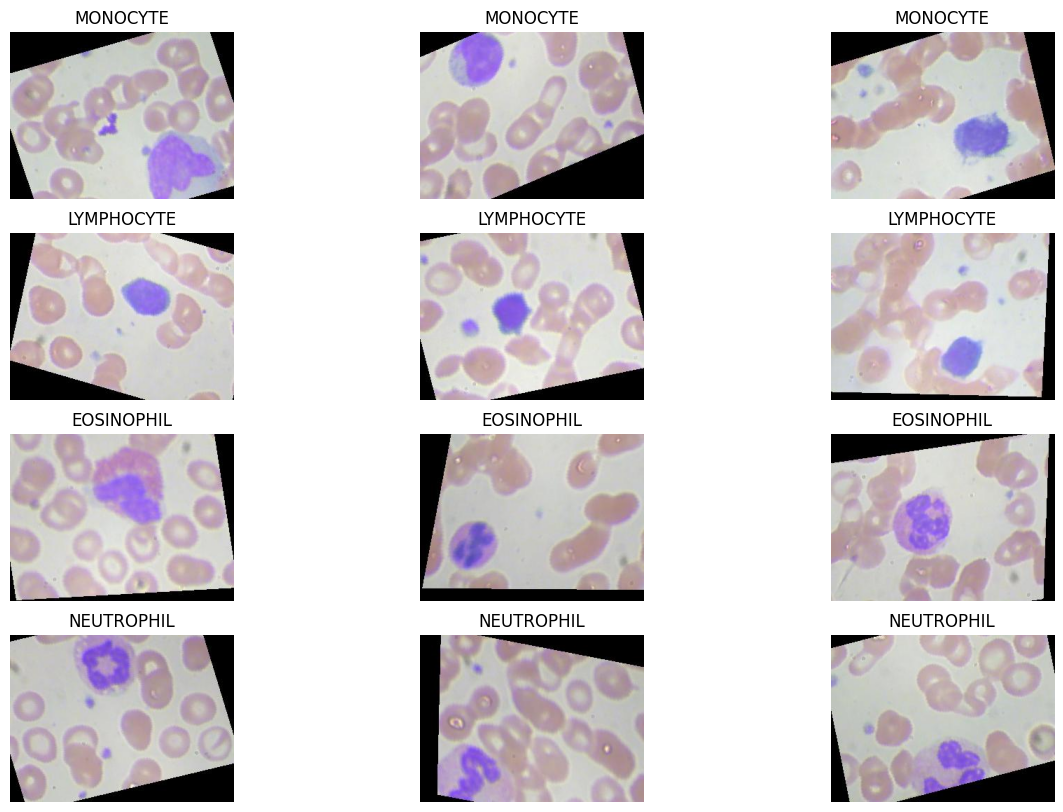

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [6]:
# Define paths
dataset_path = '/content/blood-cells/dataset2-master/dataset2-master/images'
train_path = os.path.join(dataset_path, 'TRAIN')
test_path = os.path.join(dataset_path, 'TEST')

# Check class distribution
classes = os.listdir(train_path)
print("Classes:", classes)

# Visualize sample images
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    for j in range(3):
        img_path = os.path.join(train_path, class_name, os.listdir(os.path.join(train_path, class_name))[j])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
plt.show()

# Data preprocessing
img_size = 224  # Standard size for transfer learning models
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% for validation
)

# For validation and test - no augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


In [7]:
def create_model(base_model_name='VGG16', num_classes=4):
    # Select base model
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    elif base_model_name == 'EfficientNet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    else:
        raise ValueError("Unknown base model name")

    # Freeze base model layers
    base_model.trainable = False

    # Create new model on top
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = create_model(base_model_name='VGG16')
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras',  # Changed from .h5 to .keras
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max',
                            verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1)

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=30,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.3204 - loss: 1.3984
Epoch 1: val_accuracy improved from -inf to 0.46825, saving model to best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 154s 565ms/step - accuracy: 0.3206 - loss: 1.3981 - val_accuracy: 0.4682 - val_loss: 1.2001 - learning_rate: 0.0010
Epoch 2/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4791 - loss: 1.1854
Epoch 2: val_accuracy improved from 0.46825 to 0.49748, saving model to best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 186s 550ms/step - accuracy: 0.4792 - loss: 1.1853 - val_accuracy: 0.4975 - val_loss: 1.1156 - learning_rate: 0.0010
Epoch 3/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.5347 - loss: 1.0791
Epoch 3: val_accuracy improved from 0.49748 to 0.60736, saving model to best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 137s 551ms/step - accuracy: 0.5347 - loss: 1.0791 - val_accuracy: 0.6074 - val_loss: 0.9817 - learning_rate: 0.0010
Epoch 4/30
249/249 ━━━━━━━━━━━━━━━━━━

In [9]:
# Load best model

model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test set



test_loss, test_acc = model.evaluate(test_generator)

print(f'Test Accuracy: {test_acc*100:.2f}%')

# Generate predictions

y_pred = model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

# Classification report

print(classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion matrix

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')

plt.xlabel('Predicted')

plt.ylabel('True')

plt.show()

# Plot training history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Over Epochs')

plt.legend()

plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Over Epochs')

plt.legend()

plt.show()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/step - accuracy: 0.5475 - loss: 1.0073
Test Accuracy: 61.36%
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step
              precision    recall  f1-score   support

    MONOCYTE       0.44      0.43      0.44       623
  LYMPHOCYTE       0.83      0.78      0.80       620
  EOSINOPHIL       0.52      0.53      0.52       620
  NEUTROPHIL       0.67      0.72      0.69       624

    accuracy                           0.61      2487
   macro avg       0.62      0.61      0.61      2487
weighted avg       0.62      0.61      0.61      2487



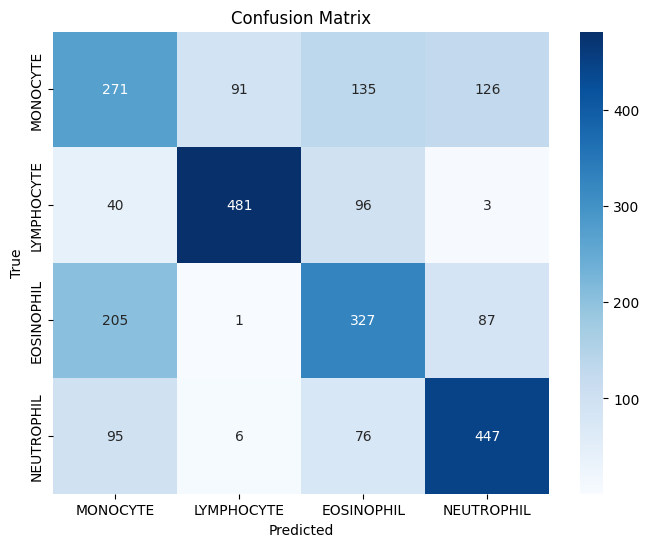

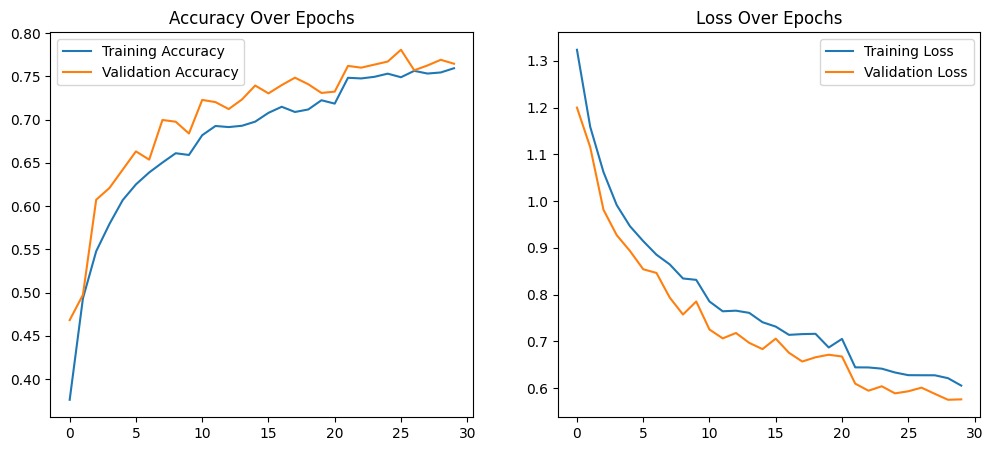

In [10]:
# Load best model
model = tf.keras.models.load_model('best_model.keras')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc*100:.2f}%')

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [11]:
# Save the final model
model.save('hematolvision_final_model.keras')

# Convert to TensorFlow Lite for mobile deployment (optional)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('hematolvision_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmple8cbpqf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135350915423440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350915424016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350905081296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350905080720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350905078608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350905080912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350905079184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350905080528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350905081680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135350905078224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1353509050841

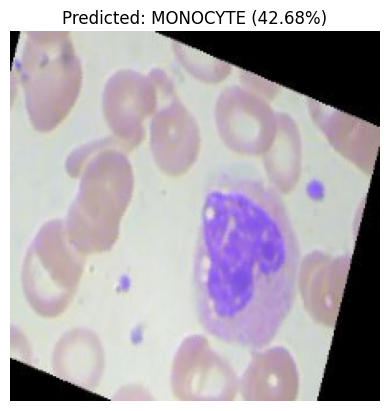

Cell Type: MONOCYTE, Confidence: 42.68%


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def automated_cell_count(image_path, img_size=224):  # Added img_size as parameter
    # Load image
    img = cv2.imread(image_path)

    # Check if image was loaded correctly
    if img is None:
        raise FileNotFoundError(f"Image not found or invalid path: {image_path}")

    # Preprocess
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict
    pred = model.predict(img, verbose=0)  # Silent prediction
    class_idx = np.argmax(pred)
    confidence = np.max(pred)
    class_name = classes[class_idx]  # Ensure `classes` is defined

    # Display
    plt.imshow(img[0])
    plt.title(f'Predicted: {class_name} ({confidence*100:.2f}%)')
    plt.axis('off')
    plt.show()

    return class_name, confidence

# Example usage
image_path = '/content/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_0_222.jpeg'
try:
    cell_type, confidence = automated_cell_count(image_path)
    print(f"Cell Type: {cell_type}, Confidence: {confidence*100:.2f}%")
except Exception as e:
    print(f"Error: {e}")

In [14]:
def diagnose_condition(cell_counts):
    """
    cell_counts: dictionary with counts for each cell type
    Example: {'EOSINOPHIL': 50, 'LYMPHOCYTE': 200, 'MONOCYTE': 30, 'NEUTROPHIL': 150}
    """
    total_cells = sum(cell_counts.values())
    percentages = {k: (v/total_cells)*100 for k, v in cell_counts.items()}

    # Basic diagnostic rules (simplified for example)
    conditions = []

    # Check for potential leukemia
    if percentages['LYMPHOCYTE'] > 50 and percentages['NEUTROPHIL'] < 20:
        conditions.append("Potential Lymphocytic Leukemia")

    # Check for potential anemia
    if percentages['EOSINOPHIL'] > 10:
        conditions.append("Possible Parasitic Infection or Allergic Reaction")
    if percentages['MONOCYTE'] > 12:
        conditions.append("Possible Chronic Inflammation or Infection")

    if not conditions:
        conditions.append("Normal blood cell distribution detected")

    return percentages, conditions

# Example usage
sample_counts = {'EOSINOPHIL': 45, 'LYMPHOCYTE': 210, 'MONOCYTE': 35, 'NEUTROPHIL': 140}
percentages, diagnosis = diagnose_condition(sample_counts)

print("Blood Cell Percentages:")
for cell, percent in percentages.items():
    print(f"{cell}: {percent:.1f}%")

print("\nDiagnostic Indicators:")
for condition in diagnosis:
    print(f"- {condition}")


Blood Cell Percentages:
EOSINOPHIL: 10.5%
LYMPHOCYTE: 48.8%
MONOCYTE: 8.1%
NEUTROPHIL: 32.6%

Diagnostic Indicators:
- Possible Parasitic Infection or Allergic Reaction


In [15]:
# This would typically be implemented as a Flask/FastAPI service
# Here's a simplified Colab version

from IPython.display import display, HTML
import ipywidgets as widgets

# Create a simple UI
upload = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
button = widgets.Button(description="Analyze")
output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        if not upload.value:
            print("Please upload an image first")
            return

        # Get the uploaded file
        for filename, data in upload.value.items():
            with open(filename, 'wb') as f:
                f.write(data['content'])

            # Analyze the image
            cell_type, confidence = automated_cell_count(filename)
            print(f"Analysis Result:")
            print(f"Cell Type: {cell_type}")
            print(f"Confidence: {confidence*100:.2f}%")

            # Basic diagnostic suggestion
            if cell_type == 'LYMPHOCYTE' and confidence > 0.7:
                print("\nNote: Elevated lymphocytes may indicate viral infection or lymphocytic leukemia.")
            elif cell_type == 'NEUTROPHIL' and confidence > 0.7:
                print("\nNote: Elevated neutrophils often indicate bacterial infection.")

button.on_click(on_button_click)

display(HTML("<h3>Remote Blood Cell Analysis</h3>"))
display(HTML("<p>Upload a blood cell microscopic image for analysis:</p>"))
display(upload)
display(button)
display(output)


FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Upload')

Button(description='Analyze', style=ButtonStyle())

Output()

In [19]:
from google.colab import files

# Save your notebook
!jupyter nbconvert --to script HematolVision_Blood_Cell_Classification.ipynb

# Download files
files.download('HematoVision_Blood_Cell_Classification.ipynb')
files.download('HematoVision_Blood_Cell_Classification.py')  # Converted version
files.download('best_model.keras')  # Your trained model
files.download('hematovision_final_model.keras')  # Final model if you have it

[NbConvertApp] WARNING | pattern 'HematolVision_Blood_Cell_Classification.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.an

FileNotFoundError: Cannot find file: HematoVision_Blood_Cell_Classification.ipynb

In [20]:
!apt-get install git -y
!git config --global user.name "Manvitha0920"
!git config --global user.email "manvithadesu3@gmail.com"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [21]:
# Clone your empty GitHub repo

!git clone https://github.com/Manvitha0920/HematolVision.git

%cd HematolVision

# Save your notebook as a Python script (optional)

!jupyter nbconvert --to script HematoVision_Blood_Cell_Classification.ipynb

# Copy files to the repo folder

!cp /content/HematoVision_Blood_Cell_Classification.ipynb .

!cp /content/HematoVision_Blood_Cell_Classification.py .  # If converted

!cp /content/best_model.keras .  # If you have model files

# Add a README (optional)

!echo "# HematolVision: AI Blood Cell Classifier" > README.md

# Push to GitHub

!git add .

!git commit -m "First commit: Added Colab notebook and model"

!git push origin main


Cloning into 'HematolVision'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'HematolVision'
/content
[NbConvertApp] WARNING | pattern 'HematoVision_Blood_Cell_Classification.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    